# Trending YouTube Video Analysis

Answering the following questions for trending videos in the US using Python libraries and SQL syntax using the dataset available from https://www.kaggle.com/datasets/datasnaek/youtube-new:
- How many views do trending videos have? Is having a large view-count needed for a video to become trending?
- Which video remained trending the longest?
- How many trending videos contain a fully-capitalized word in their titles? Is this associated with view count?
- What are the lengths of trending video titles? Is this associated with view count?
- Are views, likes, comment count, title length, and other attributes correlated with each other?
- What are the most common words in trending video titles?
- Which YouTube channels have the largest number of trending videos?
- Which video category (e.g. Entertainment, Gaming, Comedy, etc.) has the largest number of trending videos?
- When were trending videos published? On which days of the week?

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pandasql import sqldf
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# first 5 rows of dataset
df = pd.read_csv(r'C:~\Trending YouTube Video Statistics\USvideos.csv')
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/shantellmartin\nCANDICE - https://www.lovebilly.com\n\nfilmed this video in 4k on this -- http://amzn.to/2sTDnRZ\nwith this lens -- http://amzn.to/2rUJOmD\nbig drone - http://tinyurl.com/h4ft3oy\nOTHER GEAR --- http://amzn.to/2o3GLX5\nSony CAMERA http://amzn.to/2nOBmnv\nOLD CAMERA; http://amzn.to/2o2cQBT\nMAIN LENS; http://amzn.to/2od5gBJ\nBIG SONY CAMERA; http://amzn.to/2nrdJRO\nBIG Canon CAMERA; http://tinyurl.com/jn4q4vz\nBENDY TRIPOD THING; http://tinyurl.com/gw3ylz2\nYOU NEED THIS FOR THE BENDY TRIPOD; http://tinyurl.com/j8mzzua\nWIDE LENS; http://tinyurl.com/jkfcm8t\nMORE EXPENSIVE WIDE LENS; http://tinyurl.com/zrdgtou\nSMALL CAMERA; http://tinyurl.com/hrrzhor\nMICROPHONE; http://tinyurl.com/zefm4jy\nOTHER MICROPHONE; http://tinyurl.com/jxgpj86\nOLD DRONE (cheaper but still great);http://tinyurl.com/zcfmnmd\n\nfollow me; on http://instagram.com/caseyneistat\non https://www.facebook.com/cneistat\non https://twitter.com/CaseyNeistat\n\namazing intro song by https://soundcloud.com/discoteeth\n\nad disclosure. THIS IS NOT AN AD. not selling or promoting anything. but samsung did produce the Shantell Video as a 'GALAXY PROJECT' which is an initiative that enables creators like Shantell and me to make projects we might otherwise not have the opportunity to make. hope that's clear. if not ask in the comments and i'll answer any specifics.
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with John Oliver (HBO),LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week tonight donald trump""|""john oliver trump""|""donald trump""",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John Oliver discusses what we've learned so far and enlists our catheter cowboy to teach Donald Trump what he hasn't.\n\nConnect with Last Week Tonight online...\n\nSubscribe to the Last Week Tonight YouTube channel for more almost news as it almost happens: www.youtube.com/user/LastWeekTonight\n\nFind Last Week Tonight on Facebook like your mom would: http://Facebook.com/LastWeekTonight\n\nFollow us on Twitter for news about jokes and jokes about news: http://Twitter.com/LastWeekTonight\n\nVisit our official site for all that other stuff at once: http://www.hbo.com/lastweektonight"
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Lele Pons",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""|""racist""|""superman""|""love""|""rudy mancuso poo bear black white official music video""|""iphone x by pineapple""|""lelepons""|""hannahstocking""|""rudymancuso""|""inanna""|""anwar""|""sarkis""|""shots""|""shotsstudios""|""alesso""|""anitta""|""brazil""|""Getting My Driver's License | Lele Pons""",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► https://www.youtube.com/channel/UC5jkXpfnBhlDjqh0ir5FsIQ?sub_confirmation=1\n\nTHANKS FOR WATCHING! LIKE & SUBSCRIBE FOR MORE VIDEOS!\n-----------------------------------------------------------\nFIND ME ON: \nInstagram | http://instagram.com/rudymancuso\nTwitter | http://twitter.com/rudymancuso\nFacebook | http://facebook.com/rudymancuso\n\nCAST: \nRudy Mancuso | http://youtube.com/c/rudymancuso\nLele Pons | http://youtube.com/c/lelepons\nKing Bach | https://youtube.com/user/BachelorsPadTv\n\nVideo Effects: \nCaleb Natale | https://instagram.com/calebnatale\n\nPA:\nPaulina Gregory\n\n\nShots Studios Channels:\nAle

In [3]:
df.info() # nulls only appear 'description' column --> some videos do not have a description

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                40949 non-null  object
 1   trending_date           40949 non-null  object
 2   title                   40949 non-null  object
 3   channel_title           40949 non-null  object
 4   category_id             40949 non-null  int64 
 5   publish_time            40949 non-null  object
 6   tags                    40949 non-null  object
 7   views                   40949 non-null  int64 
 8   likes                   40949 non-null  int64 
 9   dislikes                40949 non-null  int64 
 10  comment_count           40949 non-null  int64 
 11  thumbnail_link          40949 non-null  object
 12  comments_disabled       40949 non-null  bool  
 13  ratings_disabled        40949 non-null  bool  
 14  video_error_or_removed  40949 non-null  bool  
 15  de

In [4]:
print('No. of trending videos =', df.video_id.nunique())
print('No of videos w/ no description =', df.drop_duplicates(subset='video_id').description.isna().sum())
# 102 out of 63251 trending videos had no description

No. of trending videos = 6351
No of videos w/ no description = 102


In [7]:
# changing date columns' formats (publish_time and trending_date)
df['publish_time'] = pd.to_datetime(df.publish_time, yearfirst=True).dt.date
df['trending_date'] = pd.to_datetime(df.trending_date, format='%y.%d.%m').dt.date
df[['publish_time','trending_date']].head()

,publish_time,trending_date
0,2017-11-13,2017-11-14
1,2017-11-13,2017-11-14
2,2017-11-12,2017-11-14
3,2017-11-13,2017-11-14
4,2017-11-12,2017-11-14


In [9]:
print(df.publish_time.sort_values().iloc[0],df.publish_time.sort_values().iloc[-1])
print(df.trending_date.sort_values().iloc[0],df.trending_date.sort_values().iloc[-1])

# dates of published videos range from 23rd July 2006 to 14th June 2018
# dates of trending videos range from 14th November 2017 to 14th June 2018

2006-07-23 2018-06-14
2017-11-14 2018-06-14


**How many views do trending videos have?**

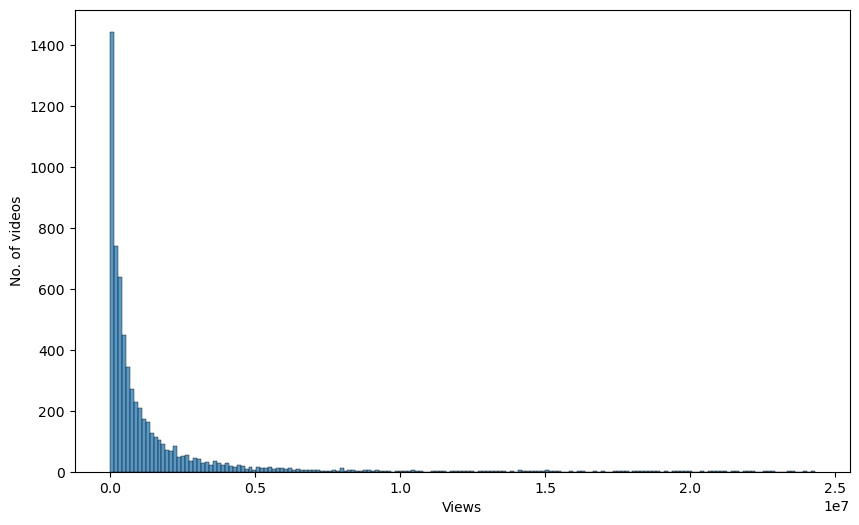

In [63]:
# filtered for trending videos w/ less than 200,000,000 view
plt.figure(figsize=(10,6))
sns.histplot(data=sqldf('''
select views
FROM (
    SELECT views,
    ROW_NUMBER() OVER (partition by video_id order by trending_date desc) as last_trending_day
    FROM df
    )
where last_trending_day = 1 and views < 2.5e7 -- 25000000 --  views < 2e7
'''),x='views')
plt.xlabel('Views')
plt.ylabel('No. of videos');

The vast majority of trending videos have ~ 5,000,000 (0.5e7) or less views by the last day they remain trending

In [62]:
print('The maximum number of views a trending video had =', df.views.max())

The maximum number of views a trending video had = 225211923


**How many likes and comments do trending videos have?**

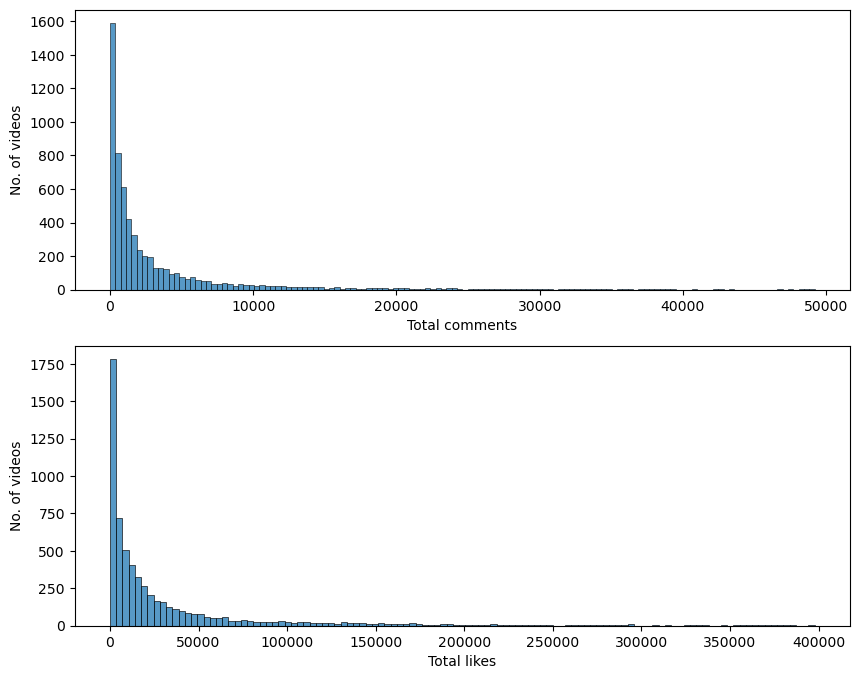

In [68]:
fig,axs = plt.subplots(2,1,figsize=(10,8))
sns.histplot(data=sqldf('''
SELECT comment_count
FROM (
    SELECT comment_count,
    ROW_NUMBER() OVER (partition by video_id order by trending_date desc) as last_trending_day
    FROM df
    )
where last_trending_day = 1 and comment_count < 50000
'''),x='comment_count',ax=axs[0])

sns.histplot(data=sqldf('''
SELECT likes
FROM (
    SELECT likes,
    ROW_NUMBER() OVER (partition by video_id order by trending_date desc) as last_trending_day
    FROM df
    )
where last_trending_day = 1 and likes < 400000
'''),x='likes',ax=axs[1])

axs[0].set_xlabel('Total comments')
axs[1].set_xlabel('Total likes')
axs[0].set_ylabel('No. of videos')
axs[1].set_ylabel('No. of videos')
axs[0].ticklabel_format(style='plain', axis='both')
axs[1].ticklabel_format(style='plain', axis='both')

In [25]:
print('The maximum number of comments a video has had =', df.groupby('video_id').comment_count.sum().max())
print('The maximum number of likes a video has had =', df.groupby('video_id').likes.sum().max())

The maximum number of comments a video has had = 15568561
The maximum number of likes a video has had = 96700818


Which video remained trending the longest?

In [84]:
sqldf('''
SELECT channel_title, video_id, title, publish_time, count(trending_date) AS no_of_days_trending
FROM df
WHERE video_id IN 
    (
    SELECT video_id
    FROM 
        (
        SELECT video_id, count(video_id)
        FROM df
        GROUP BY video_id
        ORDER BY COUNT(video_id) DESC 
        LIMIT 1
        )
    ) 
GROUP BY 1,2,3,4;
''')

,channel_title,video_id,title,publish_time,no_of_days_trending
0,Lucas and Marcus,j4KvrAUjn6c,WE MADE OUR MOM CRY...HER DREAM CAME TRUE!,2018-05-13,30


**Which YouTube channels have the largest number of trending videos?**

In [85]:
# top 5 channels in terms of highest num of videos that've gone trending
sqldf('''
SELECT channel_title, COUNT(distinct(video_id)) AS num_vids
FROM df 
GROUP BY channel_title 
ORDER BY num_vids DESC
LIMIT 5;
''')

,channel_title,num_vids
0,ESPN,84
1,TheEllenShow,74
2,The Tonight Show Starring Jimmy Fallon,72
3,Jimmy Kimmel Live,70
4,The Late Show with Stephen Colbert,58


**How many trending videos contain a fully-capitalized word in their titles?**

Titles containing a capitalised word: 
 Non-capitalised    49671
Capitalised         6638
dtype: int64 

Titles containing only capitalised words: 
 Non-capitalised    6112
Capitalised         343
dtype: int64 



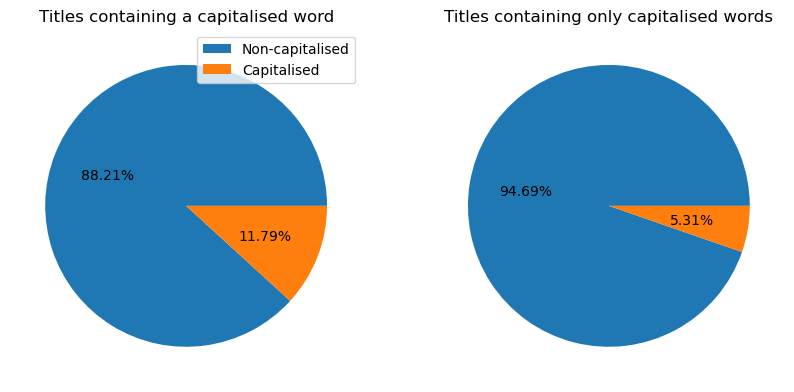

In [86]:
fig,axs = plt.subplots(1,2,figsize=(10,10))
capitalised_1 = ['Capitalised' if e.isupper() else 'Non-capitalised' for i in df.title.unique() for e in i.split()]
capitalised_2 = ['Capitalised' if i.isupper() else 'Non-capitalised' for i in df.title.unique()]
print('Titles containing a capitalised word:','\n', pd.Series(capitalised_1).value_counts(),'\n')
print('Titles containing only capitalised words:','\n', pd.Series(capitalised_2).value_counts(),'\n')
axs[0].pie(pd.Series(capitalised_1).value_counts(),autopct='%.2f%%')
axs[1].pie(pd.Series(capitalised_2).value_counts(),autopct='%.2f%%')
axs[0].set_title('Titles containing a capitalised word')
axs[1].set_title('Titles containing only capitalised words')
axs[0].legend(pd.Series(capitalised_2).value_counts().index);

What are the lengths of trending video titles? Is this length related to the video becoming trendy?

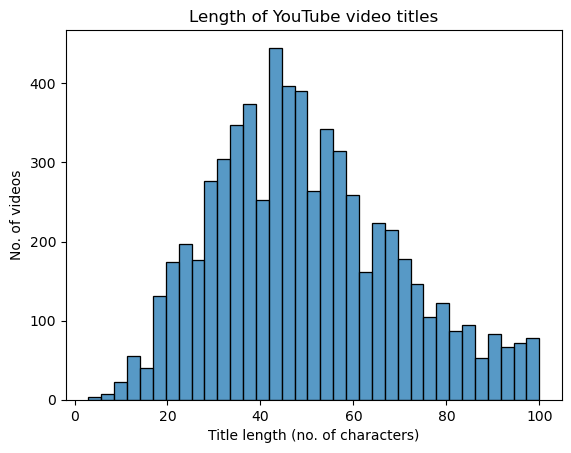

In [88]:
sns.histplot([len(i) for i in df.title.unique()])
plt.title('Length of YouTube video titles')
plt.ylabel('No. of videos')
plt.xlabel('Title length (no. of characters)');

video title length vs views

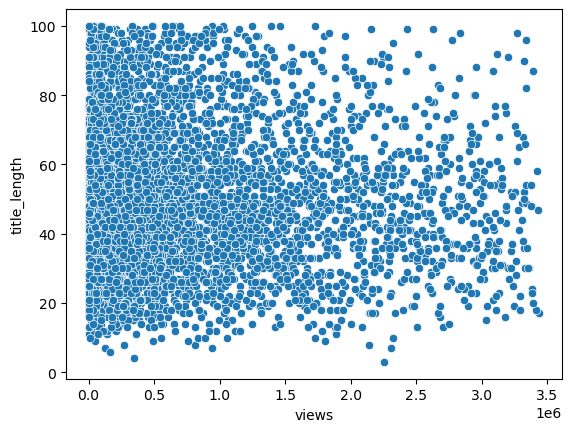

In [95]:
# return distinct video titles and their character lengths
title_length_vs_views = sqldf('''
WITH a AS (SELECT title, views
FROM (
    SELECT title, views,
    ROW_NUMBER() OVER (partition by video_id order by trending_date desc) as last_trending_day
    FROM df
    )
where last_trending_day = 1),

b AS (SELECT distinct title, length(title) title_length 
from df)

select a.title,a.views, title_length
from a
join b
on a.title = b.title''')

# removing outliers if video views 1.5x above or below IQR 
quantile1,quantile3 = np.quantile(title_length_vs_views.views,[.25,.75])
iqr = quantile3-quantile1
upper_bound,lower_bound = quantile3 + (iqr*1.5), quantile1 - (iqr*1.5)
title_length_vs_views_filter = title_length_vs_views[title_length_vs_views.views.between(lower_bound,upper_bound)]

sns.scatterplot(data=title_length_vs_views_filter,x='views',y='title_length');

**On average, how long does it take for a video to become trending?**

In [96]:
# avg num of days for a vid to be trending (1st day it becomes trending after publish date)
sqldf(''' 
SELECT AVG(daydiff) 
FROM (
    SELECT JULIANDAY(trending_date) - JULIANDAY(publish_time) AS daydiff
    FROM (
        SELECT publish_time, trending_date, video_id, rank() over (PARTITION BY video_id ORDER BY trending_date2) AS rank
        FROM df 
        ) 
    WHERE rank = 1
    )
''')

,AVG(daydiff)
0,22.442824


In [76]:
# top 5 videos w/ largest time gap between their published dates and their first day trending
sqldf('''
SELECT publish_time2, trending_date2, JULIANDAY(trending_date2) - JULIANDAY(publish_time2) AS daydiff
FROM (
    SELECT publish_time,publish_time2,trending_date2, trending_date2, video_id, rank() over (partition by video_id order by trending_date2 desc) as rank
    FROM df 
    ) 
WHERE rank = 1
ORDER BY daydiff DESC
''').head()

,publish_time2,trending_date2,daydiff
0,2006-07-23,2018-02-05,4215.0
1,2008-04-05,2018-01-09,3566.0
2,2008-06-17,2017-11-28,3451.0
3,2008-08-07,2017-11-28,3400.0
4,2009-03-10,2017-11-20,3177.0


**How are views, likes, dislikes, comment count, title length, and other attributes correlate with (relate to) each other? How are they connected?**

Text(0.5, 0, 'No. of views')

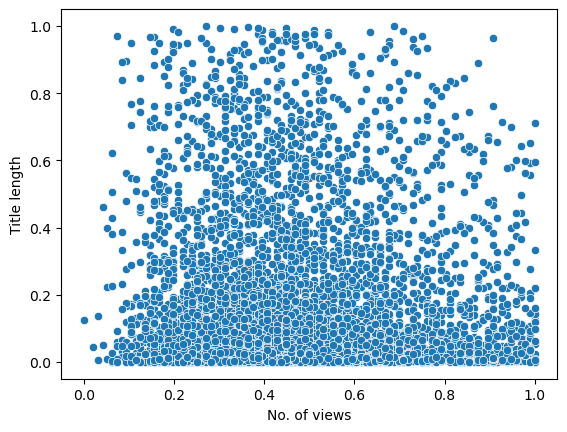

In [93]:
sns.scatterplot(data=title_length_vs_views_filter,y='views_sum_norm',x='title_length_norm')
plt.ylabel('Title length')
plt.xlabel('No. of views')

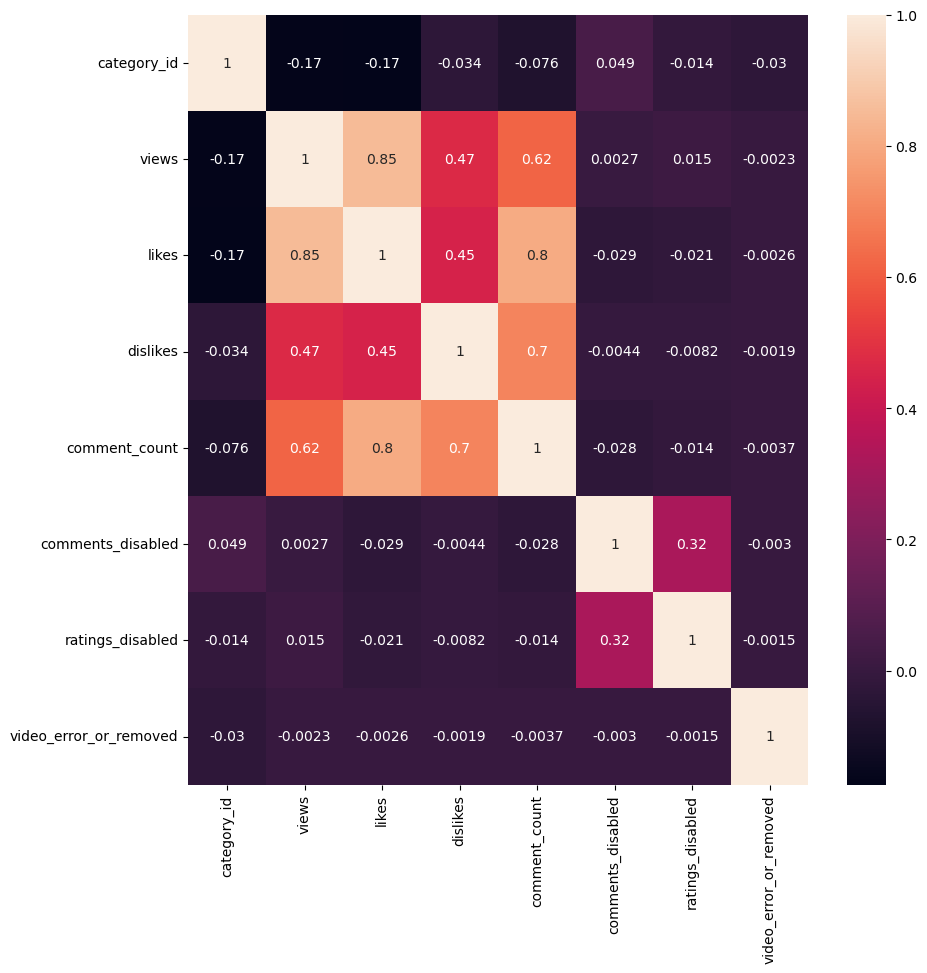

In [99]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True);

**What are the most common words in trending video titles?**

In [97]:
# e.g. 'the' appears in 1652 trending video titles
unique_titles = df.title.unique()
lst = [word.lower() for title in unique_titles for word in title.split() if word.isalpha()]
pd.Series(lst).value_counts()[:20]

the         1652
a            717
to           697
in           546
of           540
with         471
on           410
and          397
for          288
i            281
how          280
trailer      273
is           261
my           256
official     227
you          221
at           196
from         190
new          161
what         143
dtype: int64

**Which YouTube channels have the largest number of trending videos?**

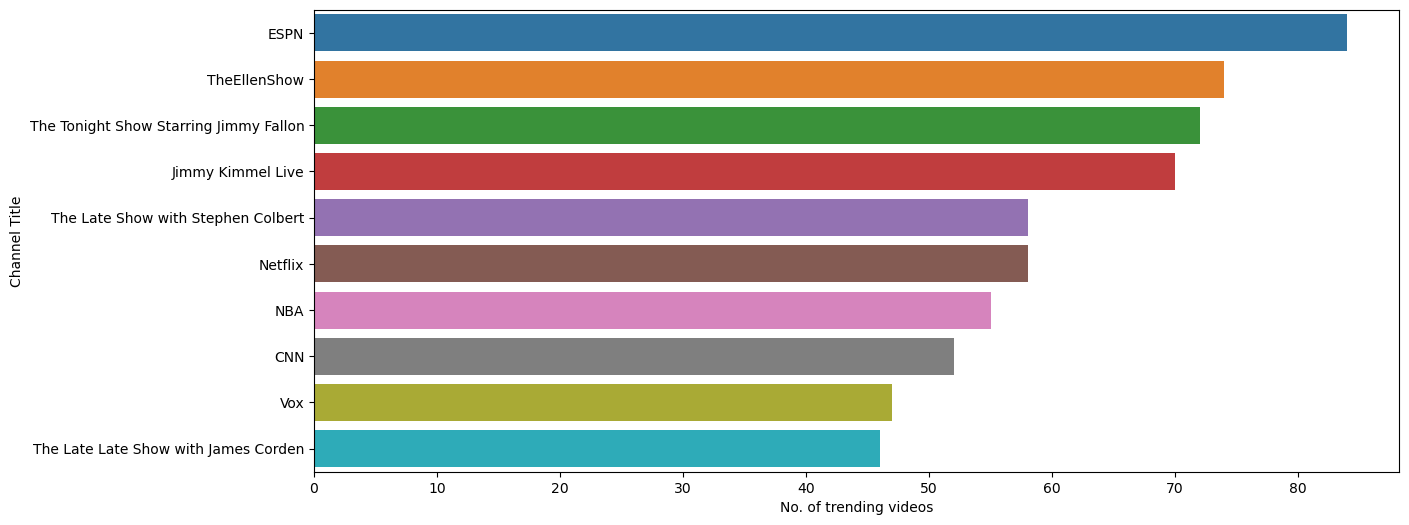

In [100]:
# Top 10 channels in terms of no. of videos that have trended
plt.figure(figsize=(14,6))
sns.barplot(data=sqldf('''
SELECT channel_title, COUNT(distinct video_id) vid_count 
FROM df
GROUP BY channel_title
ORDER BY vid_count DESC
LIMIT 10
'''),x='vid_count',y='channel_title')
plt.ylabel('Channel Title')
plt.xlabel('No. of trending videos');

**Which video category has the largest number of trending videos?**

In [101]:
import json
fo = open(r"C:~\Trending YouTube Video Statistics\US_category_id.json")
dic = json.load(fo)
cat_vals = []
for cat_id in df['category_id']:
    for json_dict in dic['items']: # dic['items'] = list of dicts
        if int(json_dict['id']) == cat_id:
            cat_vals.append(json_dict['snippet']['title'])
df['category_name'] = cat_vals

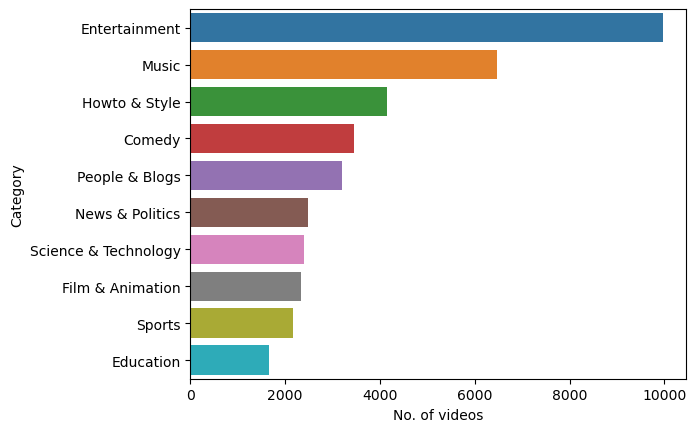

In [106]:
sns.barplot(data=sqldf('''
select category_name, count(category_name) as num_of_vids
FROM df 
GROUP BY category_name
ORDER BY num_of_vids DESC
LIMIT 10
'''),x='num_of_vids',y='category_name')
plt.xlabel('No. of videos')
plt.ylabel('Category');

**When were trending videos published? On which days of the week? at which times of the day?**

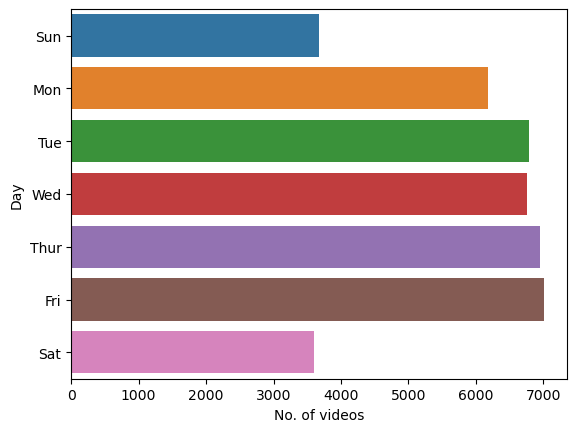

In [107]:
sns.barplot(data=sqldf('''
select strftime('%w', publish_time) as day, count(*) as numvids
from df
group by 1
''').replace({'0':'Sun','1':'Mon','2':'Tue','3':'Wed','4':'Thur','5':'Fri','6':'Sat'}),x='numvids',y='day')
plt.ylabel('Day')
plt.xlabel('No. of videos');

**How many trending videos have an error?**

No error    6348
Error          3
Name: video_error_or_removed, dtype: int64


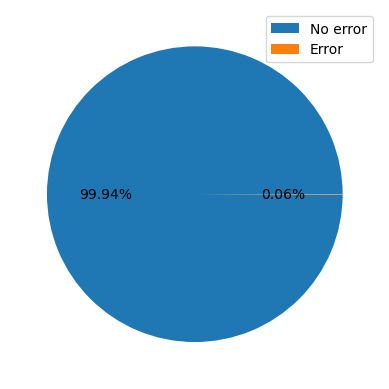

In [127]:
print(df.drop_duplicates(subset='video_id').video_error_or_removed.value_counts().rename({True:'Error', False:'No error'}))
plt.pie(df.video_error_or_removed.value_counts().rename({True:'Error', False:'No error'}),autopct='%.2f%%')
plt.legend(df.video_error_or_removed.value_counts().rename({True:'Error', False:'No error'}).index);

How many trending videos have their commets disabled?

Comments disabled    6250
Comments enabled      101
Name: comments_disabled, dtype: int64


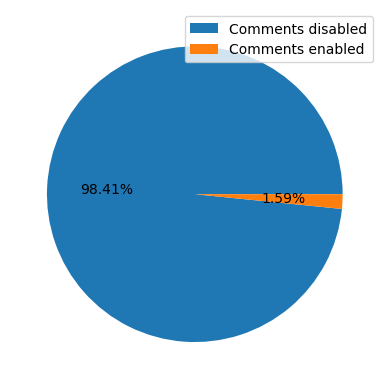

In [135]:
# True = have comments disabled; False = do not have comments disabled
print(df.drop_duplicates(subset='video_id').comments_disabled.value_counts()\
      .rename({True:'Comments enabled', False:'Comments disabled'}))
plt.pie(df.drop_duplicates(subset='video_id').comments_disabled.value_counts()\
        .rename({True:'Comments enabled', False:'Comments disabled'}),autopct='%.2f%%')
plt.legend(df.drop_duplicates(subset='video_id').comments_disabled.value_counts()\
           .rename({True:'Comments enabled', False:'Comments disabled'}).index);

How many trending videos have their ratings disabled?

Ratings disabled    6325
Ratings enabled       26
Name: ratings_disabled, dtype: int64


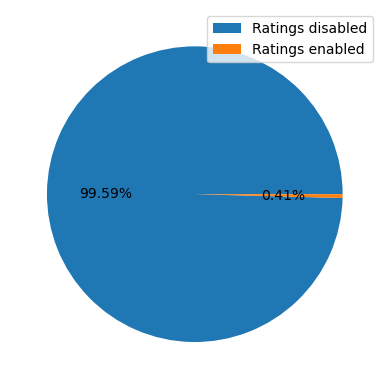

In [138]:
# True = have ratings disabled; False = do not have ratings disabled
print(df.drop_duplicates(subset='video_id').ratings_disabled.value_counts()\
     .rename({True:'Ratings enabled', False:'Ratings disabled'}))
plt.pie(df.drop_duplicates(subset='video_id').ratings_disabled.value_counts()\
        .rename({True:'Ratings enabled', False:'Ratings disabled'}),autopct='%.2f%%')
plt.legend(df.drop_duplicates(subset='video_id').ratings_disabled.value_counts()\
           .rename({True:'Ratings enabled', False:'Ratings disabled'}).index);

**How many videos have both comments and ratings disabled?**

In [142]:
print('No. of videos w/ both comments and ratings diabled =',\
    len(df[(df.comments_disabled == True) & (df.ratings_disabled == True)]))

No. of videos w/ both comments and ratings diabled = 106


# Global Analysis

In [187]:
import glob, json
df_lst = []
for file,jsn in zip(glob.glob(r"C:~\Trending YouTube Video Statistics\*videos.csv"),\
glob.glob(r"C:~\Trending YouTube Video Statistics\*json")):
    if 'JP' not in file and 'KR' not in file and 'MX' not in file and 'RU' not in file:
        df1 = pd.read_csv(file)
        df1['Country'] = file[-12:-10]
        dic = json.load(open(jsn))
        cat_vals = []
        for cat_id in df1['category_id']:
            c = 0
            for json_dict in dic['items']:
                last = dic['items'][-1]
                if int(json_dict['id']) == cat_id:
                    cat_vals.append(json_dict['snippet']['title'])
                    c+=1
                elif json_dict == last and int(json_dict['id']) != cat_id and c == 0:
                    cat_vals.append('Other')
        df1['category_name'] = cat_vals
        df_lst.append(df1)
all_df = pd.concat(df_lst)

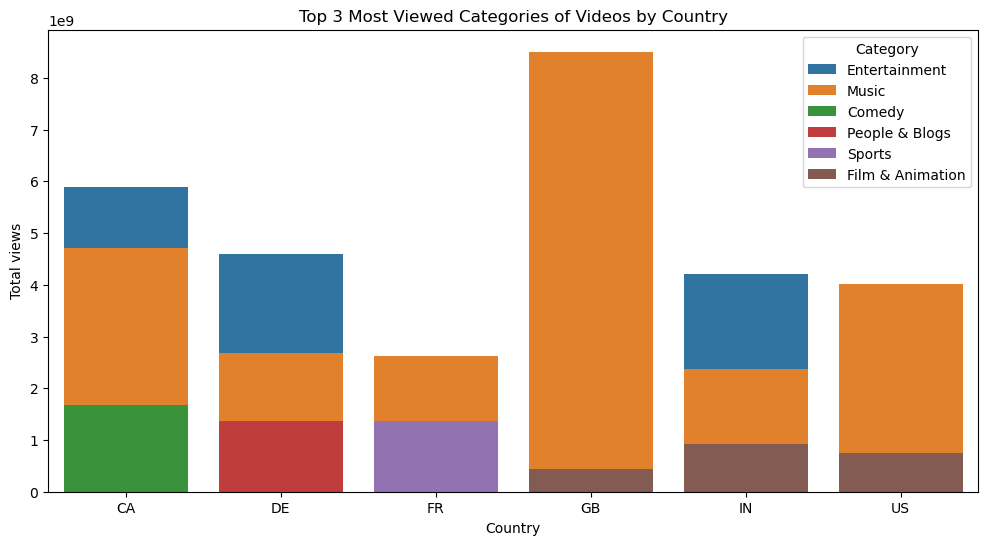

In [201]:
plt.figure(figsize=(12,6))
plt.title('Top 3 Most Viewed Categories of Videos by Country')
sns.barplot(data=sqldf('''
WITH category_views AS (
    SELECT SUM(views) sumviews, category_name, country
    FROM (
        SELECT views, category_name, country, ROW_NUMBER() over (PARTITION BY country, video_id ORDER BY trending_date DESC) AS row
        FROM all_df
        )
    WHERE row = 1 
    GROUP BY category_name,country
    )
    
SELECT sumviews, category_name, country
FROM (
    SELECT *, row_number() over (PARTITION BY country order by sumviews desc) AS row 
    FROM category_views
    )
WHERE row BETWEEN 1 AND 3
'''),y='sumviews',x='country',hue='category_name',dodge=False)

plt.legend(title='Category')
plt.ylabel('Total views')
plt.xlabel('Country');